In [1]:
# Import some of the basis required functions
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll


In [19]:
startprice = ffn.get('^GSPC:Close', start='2020-08-31',end='2020-08-31').values[0][0]

<h3>Monte Carlo Simulation</h3>

In [69]:
# Exercise 1: Monte Carlo Simulation
class MonteCarlo():
    def __init__(self,sigma = None, rf = None, K = 3300):
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        if rf==None:
            self.rf = (1+0.005/4)**4 - 1
        else:
            self.rf = rf
        if sigma == None:
            self.sigma = np.sqrt(12)*0.0428156
        else:
            self.sigma = sigma
        self.K     = K
        self.S0    = startprice
        
    def propagate(self,Sn,dT):
        phis = np.random.randn(len(Sn))
        return Sn + Sn * (self.rf*dT + self.sigma*np.sqrt(dT)*phis)
            
    def payout(self,prices,T,M):
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T) / M )* np.sum(payoff)
    
    def simulate(self,M,N,T):
        # Generate array of length M with values for phi
        dT = T/N
        prices = np.ones(M) * self.S0
        for i in range(N):
            prices = self.propagate(prices,dT)
        payout = self.payout(prices,T,M)
        return payout
    
    def stochastic_differential(self,M,T):
        phis = np.random.randn(M)
        prices = self.S0 * np.exp((self.rf - 0.5*self.sigma**2)*T
                                  +self.sigma*np.sqrt(T)*phis)
        return prices
    
    def stochastic_payout(self,M,T):
        prices = self.stochastic_differential(M,T)
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T))* np.mean(payoff)
    
    def black_scholes(self,T,call_put='call'):   
        S = self.S0
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        self.BSprice = optionprice
        
    def plot_convergence(self,M_arr,values,M_many,values_many):
        plt.figure()
        plt.scatter(M,values,color='red')
        plt.plot(M_many,values_many, color='black', label='Simulation',alpha=0.3)
        plt.ylabel('Option price at inception (USD)', size=13)
        plt.xlabel('Number of simulations', size=13)
        plt.axhline(self.BSprice, label='Black-Scholes limit',ls='dotted')
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()

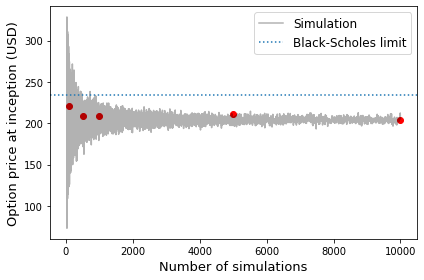

In [70]:
# Exercise a
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,3,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,3,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

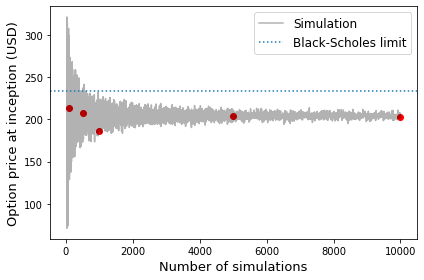

In [71]:
# Exercise b
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,63,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,63,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

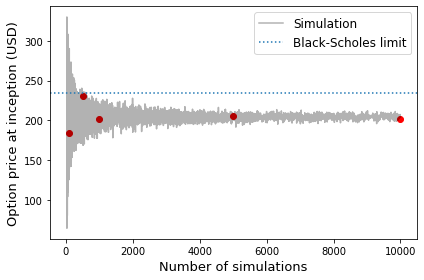

In [72]:
# Exercise c
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.stochastic_payout(w,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.stochastic_payout)(N,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

<h3>Dynamic Hedging</h3>

In [ ]:
# Situation: sell call @3300, startprice of 3300

In [135]:
class DynamicHedging():
    def __init__(self,S0,K,T,r,sigma,mu):
            self.S0 = S0
            self.K  = K
            self.T  = T
            self.rf = r
            self.sigma = sigma
            self.mu = mu
            
    def black_scholes(self,call_put='call'):   
        S = self.S0
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        self.BSprice = optionprice    
        
    def money_received(self,Ncontracts):
        self.black_scholes()
        return 100*Ncontracts*self.BSprice
    
    def propagate(self,Sn,dT):
        phis = np.random.randn(len(Sn))
        return Sn + Sn * (self.mu*dT + self.sigma*np.sqrt(dT)*phis)
            
    def payout(self,prices,T,M):
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T) / M )* np.sum(payoff)
    
    def simulate_paths(self,M,N,T):
        # Generate array of length M with values for phi
        dT = T/N
        prices = np.ones((M,N)) * self.S0
        for i in range(N-1):
            prices[:,i+1] = self.propagate(prices[:,i],dT)
        return prices
    
    def plot_paths(self,M,N,T):
        prices = self.simulate_paths(M,N,T)
        plt.figure()
        plt.plot(prices.T,color='black',lw=0.02)
        plt.ylabel('Stock price (USD)', size=13)
        plt.xlabel('Number of weeks passed', size=13)
        plt.tight_layout()   
        plt.show()
        return prices

In [136]:
# Get value at inception using BS result
startingprice = 3300
strike        = 3300
T             = 0.25
r             = np.log((1+0.005/4)**4)#-1
sigma         = np.exp(np.sqrt(12)*0.0428156)-1
mu            = 0.04

In [137]:
DH = DynamicHedging(startingprice,strike,T,r,sigma,mu)
print('Amount received is ',DH.money_received(10))

Amount received is  107221.62695149223


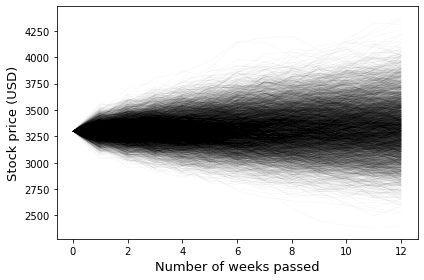

In [138]:
# Simulate paths for S&P
stockprices = DH.plot_paths(5000,13,13/52)

In [139]:
stockprices.shape

(5000, 13)